In [17]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from numpy import load
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


np.random.seed(1337)# setting the random seed value

In [18]:
# Mounting Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# path_dataset = "drive/My Drive/DL_project_LJP/ILDC_multi.csv" # path to dataset

In [20]:
dataset = pd.read_csv('ILDC_multi.csv') # loading dataset

In [21]:
# path to transformer generated chunk embeddings eg. XLNet etc.
path_transformer_chunk_embeddings_train = 'XLNet_full/XLNet_train.npy' 
path_transformer_chunk_embeddings_dev = 'XLNet_full/XLNet_dev.npy'
path_transformer_chunk_embeddings_test = 'XLNet_full/XLNet_test.npy'

In [22]:
# loading the chunk embeddings
x_train0 = load(path_transformer_chunk_embeddings_train, allow_pickle = True)
x_dev0 = load(path_transformer_chunk_embeddings_dev, allow_pickle= True)
x_test0 = load(path_transformer_chunk_embeddings_test, allow_pickle= True)

In [23]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev'] 
train = dataset.loc[dataset['split'] == 'train'] 
test = dataset.loc[dataset['split'] == 'test'] 

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])  
    
y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])

y_test0 = []
for i in range(test.shape[0]):
    y_test0.append(test.loc[i+33299,'label'])

In [24]:
from keras import layers
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input)
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask)
encoded_text1 = layers.Bidirectional(GRU(100,))(encoded_text)
# Added a dense layer after encoding
out_dense = layers.Dense(30, activation='relu')(encoded_text1)
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 768)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        522000    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              181200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 30)                6030      
                                                                 
 dense_3 (Dense)             (None, 1)                 31  

In [25]:
num_sequences = len(x_train0)
batch_size = 32 
batches_per_epoch =  int(num_sequences/batch_size)
num_features= 768
def train_generator(): # function to generate batches of corresponding batch size
    x_list= x_train0
    y_list =  y_train0
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(x_train0[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole training data
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [26]:
num_sequences_val = len(x_dev0)
batch_size_val = 32
batches_per_epoch_val = int(num_sequences_val/batch_size_val)
num_features= 768
def val_generator():# Similar function to generate validation batches
    x_list= x_dev0
    y_list =  y_dev0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(x_dev0[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), 0)
            y_train = np.zeros((batch_size_val,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole validation data
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [27]:
# Setting the callback and training the model
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

history = model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=20,
                    validation_data=val_generator(), validation_steps=batches_per_epoch_val, callbacks =[call_reduce])

Epoch 1/20


C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_12812\3718236874.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=20,


1009/1009 [==============================] - 116s 99ms/step - loss: 0.4491 - acc: 0.7873 - val_loss: 0.6452 - val_acc: 0.6724 - lr: 0.0010
Epoch 2/20
1009/1009 [==============================] - 80s 80ms/step - loss: 0.4309 - acc: 0.7970 - val_loss: 0.6609 - val_acc: 0.5514 - lr: 0.0010
Epoch 3/20
1009/1009 [==============================] - ETA: 0s - loss: 0.4187 - acc: 0.8036
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
1009/1009 [==============================] - 79s 78ms/step - loss: 0.4187 - acc: 0.8036 - val_loss: 0.6766 - val_acc: 0.5373 - lr: 0.0010
Epoch 4/20
1009/1009 [==============================] - 83s 82ms/step - loss: 0.4040 - acc: 0.8115 - val_loss: 0.7149 - val_acc: 0.5192 - lr: 9.5000e-04
Epoch 5/20
1009/1009 [==============================] - ETA: 0s - loss: 0.3903 - acc: 0.8210
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.
1009/1009 [==============================] - 85s 84ms/step - loss: 0.3903 - acc: 0.

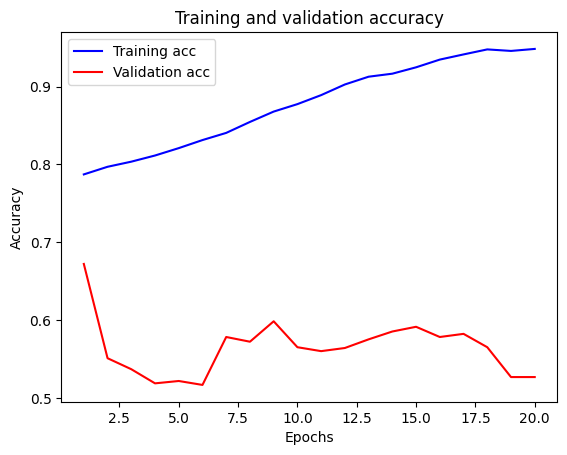

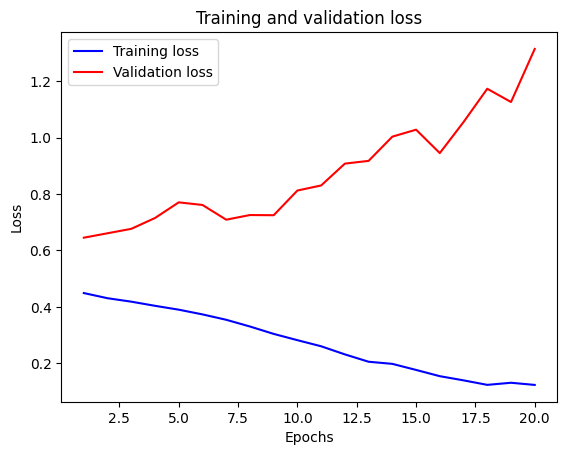

In [28]:
# Plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
num_sequences_test = len(x_test0)
batch_size_test = 32
batches_per_epoch_test = int(num_sequences_test/batch_size_test) + 1
num_features= 768

def test_generator(): # function to generate batches of corresponding batch size
    x_list= x_test0
    y_list =  y_test0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test):
            if(b == batches_per_epoch_test-1): # An extra if else statement just to manage the last batch as it's size might not be equal to batch size 
              longest_index = num_sequences_test - 1
              timesteps = len(max(x_test0[:longest_index + 1][-batch_size_test:], key=len))
              x_train = np.full((longest_index - b*batch_size_test, timesteps, num_features), -99.)
              y_train = np.zeros((longest_index - b*batch_size_test,  1))
              for i in range(longest_index - b*batch_size_test):
                  li = b * batch_size_test + i
                  x_train[i, 0:len(x_list[li]), :] = x_list[li]
                  y_train[i] = y_list[li]
            else:
                longest_index = (b + 1) * batch_size_test - 1
                timesteps = len(max(x_test0[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
                x_train = np.full((batch_size_test, timesteps, num_features), -99.)
                y_train = np.zeros((batch_size_test,  1))
                # padding the vectors with respect to the maximum sequence of each batch and not the whole test data
                for i in range(batch_size_test):
                    li = b * batch_size_test + i
                    x_train[i, 0:len(x_list[li]), :] = x_list[li]
                    y_train[i] = y_list[li]
            yield x_train, y_train

In [37]:
# evaluating on the test data
test_loss, test_acc=  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_12812\4112675470.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc=  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)


Test Loss: 1.6150540113449097
Test Accuracy: 0.6569920778274536


In [38]:
# defining a function which calculates various metrics such as micro and macro precision, accuracy and f1
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    print("macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1")
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

In [39]:
# getting the predicted labels on the test data
preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)
y_pred = preds > 0.5
print(y_pred)

# Calculating all metrics on test data predicted label
print(metrics_calculator(y_pred, y_test0[:-1]))

C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_12812\1738313971.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)


[[ True]
 [False]
 [ True]
 ...
 [False]
 [ True]
 [ True]]
macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1
(0.6710550931131247, 0.6575506261367493, 0.6642342272889198, 0.6569920844327177, 0.6569920844327177, 0.6569920844327177)


In [40]:
# getting the predicted labels on the dev data
preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)
y_pred_dev = preds > 0.5


# Calculating all metrics on dev data predicted label
print(metrics_calculator(y_pred_dev, y_dev0[:-2]))

C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_12812\1179608765.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)


macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1
(0.5274643467989024, 0.5272177419354839, 0.5273410155367241, 0.5272177419354839, 0.5272177419354839, 0.5272177419354839)


In [34]:
# saving the trained model
model.save('BIGRU_XLNet.h5')  # creates a HDF5 file 'BIGRU_XLNet.h5'

In [35]:
# loading the model
# model = load_model('BIGRU_XLNet.h5')